In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [136]:
frogs = pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")
frogs = frogs.drop(columns=['RecordID'])
Y = frogs[['Family', 'Genus', 'Species']]
X = frogs.drop(columns=['Family', 'Genus', 'Species'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [ ]:
cs = np.logspace(-2, 3, 6)
gammas = np.logspace(-2, 3, 6)

svc = SVC(kernel='rbf', decision_function_shape='ovr')
fsvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs, 'gamma':gammas})
fsvc = fsvc.fit(X_train, Y_train['Family'])

gsvc = GridSearchCV(svc, cv =10, param_grid={'C':cs, 'gamma':gammas})
gsvc = gsvc.fit(X_train, Y_train['Genus'])
    
ssvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs, 'gamma':gammas})
ssvc = ssvc.fit(X_train, Y_train['Species'])

# fpredictions = fsvc.predict(Xf_test)

### 1(b) ii Train a SVM for each of the labels using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.

In [ ]:
print("Family Weight, Width\n",fsvc.best_params_['C'],fsvc.best_params_['gamma'] )
print("Genus Weight, Width\n",gsvc.best_params_['C'],gsvc.best_params_['gamma'] )
print("Species Weight, Width\n",ssvc.best_params_['C'],ssvc.best_params_['gamma'] )

In [ ]:
fpred = fsvc.predict(X_test)
gpred = gsvc.predict(X_test)
spred = ssvc.predict(X_test)

def scores(y_test, fpred, gpred, spred):
## Calculate exact match & Hamming
    incorrect=0
    y_test_np = y_test.to_numpy()
    for i in range(0, len(fpred)):
        if fpred[i] != y_test_np[i][0] or gpred[i] != y_test_np[i][1] or spred[i] != y_test_np[i][2]:
            incorrect += 1
    return  round(1-incorrect/len(fpred),3), round(1-incorrect/(len(fpred)*3), 3)
   
exact_match, hamming = scores(y_test, fpred, gpred, spred)
print("Exact Match Score", exact_match)
print("Hamming Score", hamming)

### 1(b) iii L1-penalized SVMs (standardized)

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

scaler = StandardScaler()
scaler.fit(X_train)
X_train_tranform = scaler.transform(X_train)

cs = np.logspace(-2, 3, 6)
# gammas = np.logspace(-2, 3, 6)
svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)

fsvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs}, n_jobs=-1)
fsvc = fsvc.fit(X_train_tranform, Y_train["Family"])

gsvc = GridSearchCV(svc, cv =10, param_grid={'C':cs}, n_jobs=-1)
gsvc = gsvc.fit(X_train_tranform,  Y_train["Genus"])

ssvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs}, n_jobs=-1)
ssvc = ssvc.fit(X_train_tranform, Y_train["Species"])



In [124]:
print("Family Weight\n",fsvc.best_params_['C'])
print("Genus Weight\n",gsvc.best_params_['C'])
print("Species Weight\n",ssvc.best_params_['C'])
scaler.fit(X_test)
X_test_transform = scaler.transform(X_test)

fpred = fsvc.predict(X_test_transform)
gpred = gsvc.predict(X_test_transform)
spred = ssvc.predict(X_test_transform)

exact_match, hamming = scores(Y_test, fpred, gpred, spred)
print("Exact Match Score", exact_match)
print("Hamming Score", hamming)


Family Weight
 10.0
Genus Weight
 10.0
Species Weight
 10.0
Exact Match Score 0.868
Hamming Score 0.956


### 1(b) iv --  Repeat 1(b) iii by using SMOTE

In [125]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
Xf_train, yf_train = smote.fit_sample(X_train_tranform,Y_train["Family"])
Xg_train, yg_train = smote.fit_sample(X_train_tranform,Y_train["Genus"])
Xs_train, ys_train = smote.fit_sample(X_train_tranform,Y_train["Species"])

svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)

fsvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs}, n_jobs=-1)
fsvc = fsvc.fit(Xf_train, yf_train)

gsvc = GridSearchCV(svc, cv =10, param_grid={'C':cs}, n_jobs=-1)
gsvc = gsvc.fit(Xg_train, yg_train)

ssvc = GridSearchCV(svc, cv = 10, param_grid={'C':cs}, n_jobs=-1)
ssvc = ssvc.fit(Xs_train, ys_train)

print("Family Weight\n",fsvc.best_params_['C'])
print("Genus Weight\n",gsvc.best_params_['C'])
print("Species Weight\n",ssvc.best_params_['C'])


Family Weight
 10.0
Genus Weight
 100.0
Species Weight
 100.0


In [128]:
fpred = fsvc.predict(X_test_transform)
gpred = gsvc.predict(X_test_transform)
spred = ssvc.predict(X_test_transform)

exact_match, hamming = scores(Y_test, fpred, gpred, spred)
print("Exact Match Score", exact_match)
print("Hamming Score", hamming)

Exact Match Score 0.865
Hamming Score 0.955


In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import warnings
## hamming distance 0.67
## hamming loss .22
warnings.filterwarnings("ignore")

best_k = {}
labels={}
def run_kmeans(X):
    
    scores={}
    for k in range(2, 51):
        kmeans = KMeans(n_clusters=k, precompute_distances=True)
        fit = kmeans.fit(X)
        predictions = kmeans.fit_predict(X)
    #     print(fit.cluster_centers_)
        scores[k] = silhouette_score(X, predictions)
    best_k = max(scores, key=scores.get)
    kmeans = KMeans(n_clusters=best_k, precompute_distances=True)
    fit = kmeans.fit(X)
    return [best_k, kmeans.labels_]


        

In [144]:
#     print(best_k)
    ## labels
    ## df.iloc[i].toList()
    ## majority for each cluster is the predicted label
    ## majority label for each cluster
#     print(fit.cluster_centers_)
info = []
for i in range(0, 50):
    info.append(run_kmeans(X))

In [214]:
## Calculate Majority Clusters

def majority_clusters(C):
    family= {1: {}, 2: {}, 3: {}, 4: {}}
    genus = {1: {}, 2: {}, 3: {}, 4: {}}
    species = {1: {}, 2: {}, 3: {}, 4: {}}
    for j in range(0, len(info[C][1])):
        true_label_f = Y["Family"].iloc[j]
        true_label_g = Y["Genus"].iloc[j]
        true_label_s = Y["Species"].iloc[j]
        if info[C][1][j] == 1:
            species[1][true_label_s] = species[1].get(true_label_s, 0) + 1
            genus[1][true_label_g] = genus[1].get(true_label_g, 0) + 1
            family[1][true_label_f] = family[1].get(true_label_f, 0) + 1
        elif info[C][1][j] == 2:
            species[2][true_label_s] = species[2].get(true_label_s, 0) + 1
            genus[2][true_label_g] = genus[2].get(true_label_g, 0) + 1
            family[2][true_label_f] = family[2].get(true_label_f, 0) + 1
        elif info[C][1][j] == 3:
            species[3][true_label_s] = species[3].get(true_label_s, 0) + 1
            genus[3][true_label_g] = genus[3].get(true_label_g, 0) + 1
            family[3][true_label_f] = family[3].get(true_label_f, 0) + 1
        else:
            species[4][true_label_s] = species[4].get(true_label_s, 0) + 1
            genus[4][true_label_g] = genus[4].get(true_label_g, 0) + 1
            family[4][true_label_f] = family[4].get(true_label_f, 0) + 1

#         majority1f = max(family[1], key=family[1].get)
#         majority2f = max(family[2], key=family[2].get)
#         majority3f = max(family[3], key=family[3].get)
#         majority4f = max(family[4], key=family[4].get)
#         majority1s = max(species[1], key=species[1].get)
#         majority2s = max(species[2], key=species[2].get)
#         majority3s = max(species[3], key=species[3].get)
#         majority4s = max(species[4], key=species[4].get)
#         majority1g = max(genus[1], key=genus[1].get)
#         majority2g = max(genus[2], key=genus[2].get)
#         majority3g = max(genus[3], key=genus[3].get)
#         majority4g = max(genus[4], key=genus[4].get)
    majority1=[max(family[1], key=family[1].get), max(genus[1], key=genus[1].get), max(species[1], key=species[1].get)]
    majority2=[max(family[2], key=family[2].get),max(genus[2], key=genus[2].get), max(species[2], key=species[2].get)]
    majority3=[max(family[3], key=family[3].get), max(genus[3], key=genus[3].get), max(species[3], key=species[3].get)]
    majority4= [max(family[4], key=family[4].get),max(genus[4], key=genus[4].get),max(species[4], key=species[4].get)]
        
    return [majority1, majority2, majority3, majority4]



### Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters

### In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species

In [227]:
# for i in range(0, len(Y["Family"])):
#     print(Y["Family"].iloc[i])
def count_mismatch(arr1, arr2):
#     print(arr1, arr2)
    count=0
    for i in range(0, len(arr1)):
        if arr1[i] != arr2[i]:
            count+=1
    return count
hamming_distances = []
for C in range(0, 50):
    mismatch=0
    majority1, majority2, majority3, majority4 = majority_clusters(C)
    print("Majorities for each cluster (1,2,3,4)\n", majority1, "\n", majority2,"\n", majority3,"\n", majority4,"\n",)
    for sample_num in range(0, len(info[C][1])):
        if info[C][1][sample_num] == 1:
            mismatch += count_mismatch([Y["Family"].iloc[sample_num], Y["Genus"].iloc[sample_num], Y["Species"].iloc[sample_num]], majority1)
        if info[C][1][sample_num] == 2:
            mismatch += count_mismatch([Y["Family"].iloc[sample_num], Y["Genus"].iloc[sample_num], Y["Species"].iloc[sample_num]], majority2)
        if info[C][1][sample_num] == 3:
            mismatch += count_mismatch([Y["Family"].iloc[sample_num], Y["Genus"].iloc[sample_num], Y["Species"].iloc[sample_num]], majority3)
        if info[C][1][sample_num] == 4:
            mismatch += count_mismatch([Y["Family"].iloc[sample_num], Y["Genus"].iloc[sample_num], Y["Species"].iloc[sample_num]], majority4)
    print("Iteration", C)
    print("Hamming Distance", mismatch/len(Y["Family"]))      
    print("Hamming Loss", mismatch/len(Y["Family"])/3) 
    print("Hamming Score", 1-(mismatch/len(Y["Family"])/3))
    print("\n")
    hamming_distances.append(mismatch/len(Y["Family"]))

            
    

Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 

Iteration 0
Hamming Distance 0.30020847810979845
Hamming Loss 0.10006949270326615
Hamming Score 0.8999305072967339


Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 

Iteration 1
Hamming Distance 0.4458651841556637
Hamming Loss 0.1486217280518879
Hamming Score 0.8513782719481121


Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 

Iteration

Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 

Iteration 23
Hamming Distance 0.4458651841556637
Hamming Loss 0.1486217280518879
Hamming Score 0.8513782719481121


Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 

Iteration 24
Hamming Distance 0.29965253648366924
Hamming Loss 0.09988417882788975
Hamming Score 0.9001158211721103


Majorities for each cluster (1,2,3,4)
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 

Iterati

Iteration 45
Hamming Distance 0.4458651841556637
Hamming Loss 0.1486217280518879
Hamming Score 0.8513782719481121


Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 

Iteration 46
Hamming Distance 0.4458651841556637
Hamming Loss 0.1486217280518879
Hamming Score 0.8513782719481121


Majorities for each cluster (1,2,3,4)
 ['Hylidae', 'Hypsiboas', 'HypsiboasCordobae'] 
 ['Hylidae', 'Hypsiboas', 'HypsiboasCinerascens'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'] 
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 

Iteration 47
Hamming Distance 0.6248783877692842
Hamming Loss 0.20829279592309471
Hamming Score 0.7917072040769053


Majorities for each cluster (1,2,3,4)
 ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'] 
 ['Dendrobatidae', 'Ameerega', 'Ameeregatrivit

### Report the average and standard deviation of the 50 Hamming Distances that you calculate

In [224]:
print("")
print("Mean: ", np.mean(hamming_distances))
print("Standard Dev: ", np.std(hamming_distances))

Mean:  0.5197025712300207
Standard Dev:  0.13575872202749084


### ISLR 10.7.2
(c) Observations 1 and 2 will be in Cluster 1
Observations 3 and 4 will be in Cluster 2

(d) Observation 4 will be in Cluster 1
Observations 1, 2, and 3 will be in Cluster 2

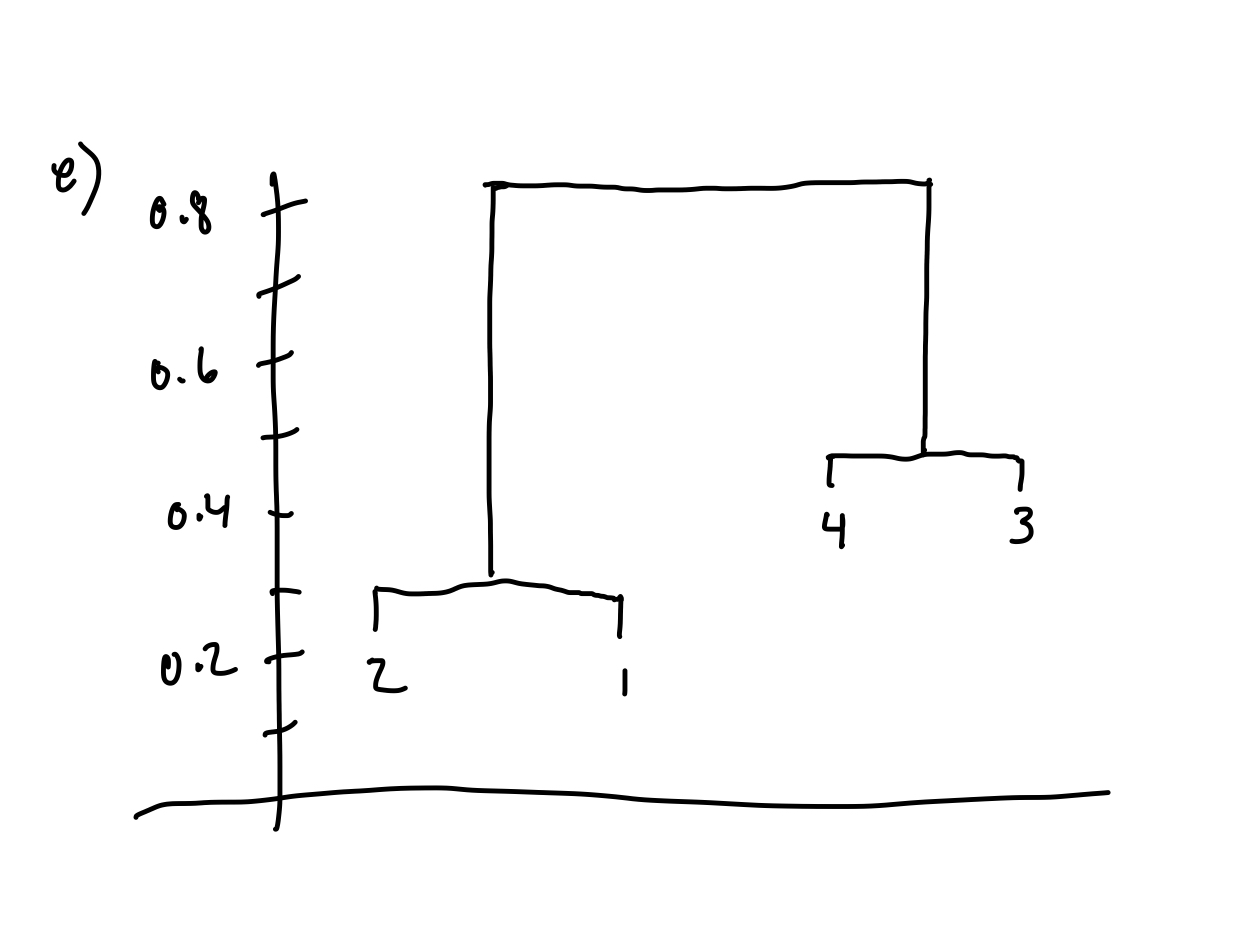

In [228]:
from IPython.display import Image

print("(A) Clusters 1 and 2 are joined at a height of 0.3, Clusters 3 and 4 are joined at a height of 0.45, and all Clusters are joined at a height of 0.8 ")
print("(B) Clusters 1 and 2 are joined at a height of 0.3, Clusters 3 and 4 are joined at a height of 0.4, and all Clusters are joined at a height of 0.45 ")

Image(filename="../data/bookproblemab.jpeg", width = 600, height = 300)


In [ ]:
print("Clusters 1 and 2 have switched places and , Clusters 3 and 4 have switched places")
Image(filename="../data/bookprobleme.jpeg", width = 600, height = 300)